# ‘Inclusive Job Ads project’ - Tech/Non-tech tagging
Author: Shravankumar Hiregoudar

## Import the libraries

In [4]:
import pandas as pd
import os
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
%matplotlib inline

## Import the technical keywords list and job excel file

In [14]:
job_ads = pd.read_excel('jobs_ads_with_Gender_Tag_tech_flag_03172022 - Validation.xlsx')
tech_words = pd.read_excel('onlyTechWords.xlsx').dropna()
tech_words_list = tech_words['Words'].tolist()

## Creating the techincal word list

In [44]:
def getAllKeywords(techTagOp):
    """
        :getAllKeywords: Get all the keywords from technical/non-technical job description.

        :param techTagOp: The input of the funcation is dataframe with just tech or non-tech jobs
        :type techTagOp: pandas.core.frame.DataFrame

        :returns: Set of unique keywords excluding special characters, stopwords and ignoring case sensitive.
    """
        
    # Tokenize
    techTagTokens = [sub.split() for sub in set(techTagOp['Text Description'].fillna(""))]
    # convert list of list to list
    techTagUnqList = set(list(itertools.chain(*techTagTokens)))
    # Remove special characters
    techTagUnqListSpl = set([re.sub('[^a-zA-Z0-9]+', '', _) for _ in techTagUnqList])
    # Remove stop words
    techTagUnqListSplStop = [word for word in techTagUnqListSpl if word not in stopwords.words('english')]
    # case insensitive
    techTagUnqListSplStopCase = set({v.casefold(): v for v in techTagUnqListSplStop}.values())
    # Non-integers only
    techTagUnq = set(sorted([item for item in techTagUnqListSplStopCase if not item.isdigit()]))
    
    return (techTagUnq)

In [41]:
opinion = job_ads.groupby('Tech Flag - Your Opinion')

techOp = opinion.get_group('Tech')             # The actual tech roles ('Tech Flag - Your Opinion')
ntechOp = opinion.get_group('Non-Tech')        # The actual non-tech roles ('Tech Flag - Your Opinion') 

##### Get all the keywords from technical/non-technical job description

In [42]:
techUnq = getAllKeywords(techOp)
ntechUnq = getAllKeywords(ntechOp)

In [45]:
onlyTech = sorted(techUnq - ntechUnq)      # The words which are only present in technical job description
onlynTech = sorted(ntechUnq - techUnq)     # The words which are only present in non-technical job description
both = sorted(techUnq & ntechUnq)          # The words which are common in both
print(len(onlyTech), len(onlynTech), len(both))

2153 667 1123


## Compare and flag

In [46]:
# Convert long string as list of strings
def stringToList(string):
    if not pd.isnull(string):
        listRes = list(string.split(" "))
        return [re.sub('[^a-zA-Z0-9]+', '', _) for _ in listRes]
    else:
        return " "

In [51]:
# Upon looping, The mappedTokens will contain list of sets, where len(list) = len(total jobs)
# Example: [ set(),{'ARM','Agile','Agilebased'},......... ] 
# implies the first job ad contains zero tech words, the second job ad contains 'ARM','Agile','Agilebased' technical words..

def mapTokens(job_ads_attribute):
    """
        :mapTokens: Get all the keywords from technical/non-technical job description. The input of the funcation is dataframe with just tech or non-tech jobs

        :param job_ads_attribute: 'Text Description' or 'Job Order: External Job Title'
        :type job_ads_attribute: pandas.core.series.Series

        :returns: List of words in 'tech_words_list' are mapped with 'Text Description' or 'Job Order: External Job Title'
    """
    mappedTokens = [] 
    for i, role in enumerate (job_ads_attribute):
        mappedTokens.append(set(stringToList(job_ads_attribute[i])) & set(tech_words_list))
    return mappedTokens

In [52]:
# What words in 'tech_words_list' are mapped with 'Text Description'
mappedTokensText = mapTokens(job_ads['Text Description'])

# What words in 'tech_words_list' are mapped with 'Job title'
mappedTokensTitle = mapTokens(job_ads['Job Order: External Job Title'])

In [53]:
def tech_tag(mappedTokensText, mappedTokensTitle):
    """
        :tech_tag: Tag the tech and non-tech based on the 'Text Description' or 'Job Order: External Job Title'

        :param mappedTokensText: List of words in 'tech_words_list' are mapped with 'Text Description'
        :type mappedTokensText: list
        
        :param mappedTokensTitle: List of words in 'tech_words_list' are mapped with 'Job Order: External Job Title'
        :type mappedTokensTitle: list

        :returns: job_ads dataframe with additional column 'Tech_Flag'
    """
    # The dummy job descriptions/ templates have this sentence in common
    dummyJD = 'Avoid using a laundry list of technologies and/or skills'

    for i in range(len(mappedTokensText)):
        # if the job 'Text Description' is empty or dummy -- Tag it based on the Job Title ; else use 'Text Description' to tag tech and non-tech.
        if not pd.isnull(job_ads['Text Description'][i]) and dummyJD not in job_ads['Text Description'][i]:
            # If we have mapped tokens between 'Text Description' and tech_words_list -> Tag 'Tech' else 'Non-Tech'
            if len(mappedTokensText[i]):
                job_ads.at[i,'Tech_Flag'] = 'Tech'
            else:
                job_ads.at[i,'Tech_Flag'] = 'Non-Tech'
        else:
            if len(mappedTokensTitle[i]):
                job_ads.at[i,'Tech_Flag'] = 'Tech'
            else:
                job_ads.at[i,'Tech_Flag'] = 'Non-Tech'
    
    return job_ads

In [54]:
job_ads = tech_tag(mappedTokensText, mappedTokensTitle)

## Analyze accuracy - Validation (Additional)

gochha -> 133 Missed -> 8


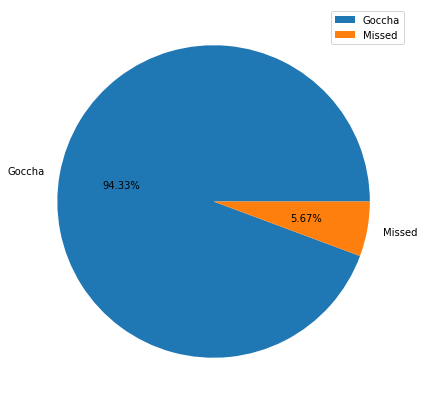

,Row Num,Role,Misclassified as,Reason
0,4,Build - US,Non-Tech,Dummy Job Description + Generic Title
1,10,CLT Versa Placeholder,Non-Tech,Dummy Job Description + Generic Title
2,45,Build - US,Non-Tech,Dummy Job Description + Generic Title
3,1683,Build - Australia,Non-Tech,Dummy Job Description + Generic Title
4,1710,Organizational Effectiveness Consultant,Tech,"Tech words in JD {'Tableau', 'PowerBI', 'Azure'}"
5,1715,Senior Consultant,Non-Tech,Dummy Job Description + Generic Title
6,1735,Technology Delivery Owner,Non-Tech,Dummy Job Description + Generic Title
7,1757,Solution Owner - Business Advisory,Tech,"Tech words in JD {'Solution', 'Agile'}"


In [56]:
#keep a count of correct and misclassification
right,wrong = 0,0

#Their are dummy job description in the dataset which has this line in common
dummyJD = 'Avoid using a laundry list of technologies and/or skills'

#List of items which will capture misclassified information
reason, role, mis, rowno = [], [], [], []


for i in range(len(job_ads['Tech_Flag'])):
    # Consider tech and non-tech only for comparision as some of the 'Tech Flag - Your Opinion' are empty
    if job_ads['Tech Flag - Your Opinion'][i] in ['Tech','Non-Tech'] :
        if job_ads['Tech_Flag'][i] == job_ads['Tech Flag - Your Opinion'][i]:
            right +=1
            pass
        else:
            wrong +=1
            
            # These jobs are misclassified based on their job descr. 
            # so, we will capture it's row num, role name, algorithm misclassified tech/non-tech and reason for misclassification
            rowno.append(i)
            role.append(job_ads['Job Order: External Job Title'][i])
            mis.append(job_ads['Tech_Flag'][i])
            
            # If the job descr. contains 'dummyJD' that means it's just a template/placeholder and not a real job descr.
            # capture the reasoning for misclassification
            if not pd.isnull(job_ads['Text Description'][i]):
                if dummyJD in job_ads['Text Description'][i]:
                    reason.append("Dummy Job Description + Generic Title")
                else:
                    reason.append("Tech words in JD "+str(mappedTokensText[i]))
            else:
                reason.append("Empty JD")

#Create a DF of misclassified jobs (includes row num, role name, algorithm misclassified tech/non-tech and reason for misclassification)
wrongDF = pd.DataFrame({'Row Num':rowno, 'Role':role, 'Misclassified as':mis, 'Reason':reason})

#Plot the correct and misclassified
print("gochha ->", right, "Missed ->", wrong)
fig = plt.figure(figsize=(7,10))
plt.pie([right,wrong] , labels = ["Goccha", "Missed"], autopct='%1.2f%%')
plt.legend()
plt.show() 
wrongDF